In [25]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython import display
import argparse
import logging
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import tsfresh
from tsfresh.feature_extraction import MinimalFCParameters
from os.path import exists

In [2]:
## FUNCTIONS ##

#Parse String
def split_ele(x):
    a = np.array(re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+", x))
    return a.astype(np.float)

def get_args():
    parser = argparse.ArgumentParser(description='Recommendations for the given song')
    parser.add_argument('-s', '--song', required=True, help='Name of Song')
    parser.add_argument('-a', '--artist', required=True, help='Name of Artist')
    return parser.parse_args()


def get_song(name_song, name_artist):
    results = sp.search(q=name_song + ' '+name_artist, type='track')
    items = results['tracks']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None

def show_recommendations_for_song(song):
    results = sp.recommendations(seed_tracks=[song['id']], limit=5)
    print("Recommendations:")
    for track in results['tracks']:
        print("TRACK: ",track['name'], " - ",track['artists'][0]['name'])
        sp.add_to_queue(track['uri'])

def show_feature_based_recommendations_for_song(song):
    song_features = sp.audio_features([song['uri']])
    kwargs = {"target_danceability":song_features[0]["danceability"], "target_energy":song_features[0]['energy'], "target_key":song_features[0]['key'], "target_loudness":song_features[0]['loudness'], "target_speechiness":song_features[0]['speechiness'], "target_acousticness":song_features[0]['acousticness'], "target_instrumentalness":song_features[0]['instrumentalness'], "target_liveness":song_features[0]['liveness'], "target_valence":song_features[0]['valence'], "target_tempo":song_features[0]['tempo'], "target_time_signature":song_features[0]['time_signature']}
    results = sp.recommendations(seed_artists=None, seed_genres=None, seed_tracks=[song['id']], limit=5, country=None, **kwargs)
    print("Feature-based Recommendations:")
    for track in results['tracks']:
        print("TRACK: ",track['name'], " - ",track['artists'][0]['name'])
        sp.add_to_queue(track['uri'])


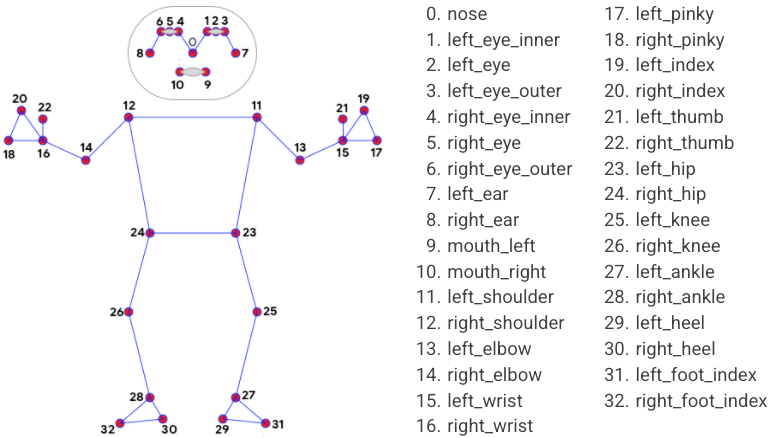

In [3]:
# READ IN FILE ##

df = pd.read_csv("slow_dancing.csv", sep = ',', usecols=range(1,34))
pose_landmark = ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT',
              'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_THUMB',
              'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']
display.Image("./pose_tracking_full_body_landmarks.png")

# VISUALIZE ONE NODE

In [4]:
# input the number and press enter
body_index = input()
print(pose_landmark[int(body_index)])

0
NOSE


C:\Users\mbase\AppData\Local\Temp/ipykernel_30776/1428599074.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return a.astype(np.float)


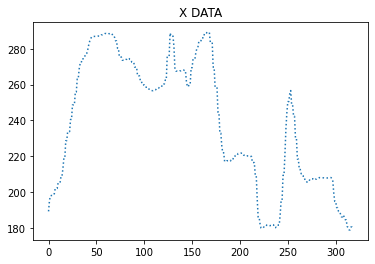

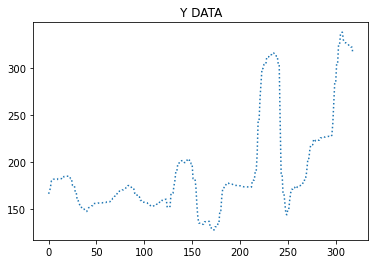

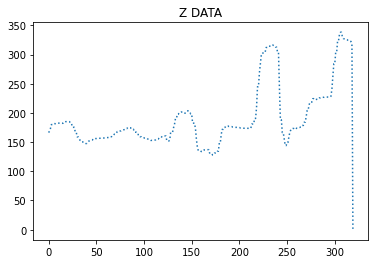

In [5]:
# Parse the column from df
body_col = df[pose_landmark[int(body_index)]].values

# Convert string to array
body_arr = [split_ele(x) for x in body_col]

# Get the x,y,z value array
body_arr_x = []
body_arr_y = []
body_arr_z = []
for i in range(len(body_arr)):
    body_arr_x = np.append(body_arr_x,body_arr[i][0])
    body_arr_y = np.append(body_arr_y,body_arr[i][1])
    body_arr_z = np.append(body_arr_y,body_arr[i][2])
    
# Plot x
plt.plot(body_arr_x, linestyle = 'dotted')
plt.title("X DATA")
plt.show()

# Plot y
plt.plot(body_arr_y, linestyle = 'dotted')
plt.title("Y DATA")
plt.show()

# Plot z
plt.plot(body_arr_z, linestyle = 'dotted')
plt.title("Z DATA")
plt.show()

# EXTRACT FEATURES

In [20]:
song_name_list = ['love_girl', 'party_rock_anthem', 'lite_spots', 'girlfriends_best_friend', 'scaredy_cat', 'girl_anachronism', 'lil_darlin', 'el_invento', 'test_drive', 'weight_in_gold', 'easy', 'comethru', 'classic', 'tongue_tied', 'motley', 'knife_talk', 'feed_the_fire', 'lose_it', 'thats_what_i_like', 'humble', 'skeletons', 'stairway_to_heaven', 'slow_dancing_in_the_dark', 'peaches', 'kilby_girl', 'jupiter_love', 'woman', 'get_up', 'throwin_elbows', 'power', 'ymca']
artist_name_list = ['cnblue', 'lmfao', 'kaytranada', 'walkabout', 'dpr_ian', 'the_dresden_dolls', 'count_basie', 'jose_gonzalez_calvaire', 'ariana_grande', 'gallant', 'wheein', 'jeremy_zucker', 'mkto', 'grouplove', 'post_malone', 'drake', 'lucky_daye', 'swmrs', 'bruno_mars', 'kendrick_lamar', 'keshi', 'led_zeppelin', 'joji', 'justin_bieber', 'backseat_lovers', 'trey_songz', 'doja_cat', 'shinedown', 'excision', 'kanye', 'village_people']
num_runs = 2

In [50]:
extracted_features = pd.DataFrame()

for file_num in range(1, num_runs+1):
    for index in range(len(song_name_list)):
        file_song = song_name_list[index]
        file_artist = artist_name_list[index]

        file_name = "data/"+str(file_num) + "_" + file_song + "_"+file_artist+".csv"
        
        #if file does not exist, skip it
        if(exists(file_name)):
            settings = MinimalFCParameters()
            num_features = 10
            num_nodes = 34
            num_samples = 10

            df = pd.read_csv(file_name, sep = ',', usecols=range(1, num_nodes))

            #CLEAN UP DATA
            x_data = pd.DataFrame(columns=pose_landmark, index=range(len(df)))
            y_data = pd.DataFrame(columns=pose_landmark, index=range(len(df)))
            z_data = pd.DataFrame(columns=pose_landmark, index=range(len(df)))
            vis_data = pd.DataFrame(columns=pose_landmark, index=range(len(df)))

            for node in pose_landmark:
                curr = df[node]
                vals = [split_ele(x) for x in curr]
                for row in range(len(vals)):
                    x_data[node][row] = vals[row][0]
                    y_data[node][row] = vals[row][1]
                    z_data[node][row] = vals[row][2]
                    vis_data[node][row] = vals[row][3]


            #MOTION FEATURE EXTRACTION
            curr_extracted_vector = pd.DataFrame()

            #LOOP THROUGH NODES
            for node in pose_landmark:
                node_x = x_data[node]
                node_y = y_data[node]
                node_z = z_data[node]

                #Every Node (Body Part) has this set of feaures

                xname = node + "_x"
                yname = node + "_y"
                zname = node + "_z"

                comb = pd.DataFrame(data=[node_x, node_y, node_z], index=[xname, yname, zname]).T
                comb.rename_axis("time")
                comb["id"] = 1
                comb["time"] = comb.index

                curr_extracted = tsfresh.extract_features(comb, column_id = "id", column_sort="time", column_kind=None, column_value=None, default_fc_parameters=settings, disable_progressbar=True)
                curr_extracted_vector = pd.concat([curr_extracted_vector, curr_extracted], axis=1)

            #SONG FEATURE EXTRACTION

            logger = logging.getLogger()
            logging.basicConfig()
            CLIENT_ID="9793440f0a5047c59c70bcfcf91ad589"
            CLIENT_SECRET= "b66dc3a5f9f34207bebee32a25745368"
            REDIRECT_URL="http://localhost/"
            client_credentials_manager = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
            oAuth = SpotifyOAuth(client_id = CLIENT_ID, client_secret = CLIENT_SECRET, redirect_uri = REDIRECT_URL, scope = 'user-modify-playback-state')
            sp = spotipy.Spotify(auth_manager =oAuth)

            song_name = file_song
            artist_name = file_artist

            song = get_song(song_name, artist_name)
            
            #if get request didnt get anything
            if(song is None):
                continue
            
            song_features = sp.audio_features([song['uri']])
            
            audio_feature_list = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
            audio_feat = pd.DataFrame(columns = audio_feature_list, index = range(1, 2))

            audio_feat['danceability'] = song_features[0].get('danceability')
            audio_feat['energy'] = song_features[0].get('energy')
            audio_feat['key'] = song_features[0].get('key')
            audio_feat['loudness'] = song_features[0].get('loudness')
            audio_feat['mode'] = song_features[0].get('mode')
            audio_feat['speechiness'] = song_features[0].get('speechiness')
            audio_feat['acousticness'] = song_features[0].get('acousticness')
            audio_feat['instrumentalness'] = song_features[0].get('instrumentalness')
            audio_feat['liveness'] = song_features[0].get('liveness')
            audio_feat['valence'] = song_features[0].get('valence')
            audio_feat['tempo'] = song_features[0].get('tempo')
            audio_feat['time_signature'] = song_features[0].get('time_signature')

            curr_extracted_vector = pd.concat([curr_extracted_vector, audio_feat], axis=1)

            extracted_features = extracted_features.append(curr_extracted_vector)

C:\Users\mbase\AppData\Local\Temp/ipykernel_30776/1428599074.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return a.astype(np.float)
C:\Users\mbase\AppData\Local\Temp/ipykernel_30776/1428599074.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return a.astype(np.float)
C:\Users\mbase\AppData\Local\Temp/ipykernel_30776/1428599074.p

C:\Users\mbase\AppData\Local\Temp/ipykernel_30776/1428599074.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return a.astype(np.float)


In [51]:
extracted_features

,NOSE_x__sum_values,NOSE_x__median,NOSE_x__mean,NOSE_x__length,NOSE_x__standard_deviation,NOSE_x__variance,NOSE_x__root_mean_square,NOSE_x__maximum,NOSE_x__absolute_maximum,NOSE_x__minimum,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1,46970.909195,219.071480,219.490230,214.0,29.641075,878.593299,221.482628,293.347717,293.347717,175.934052,...,1,-11.683,1,0.4710,0.034600,0.069800,0.1120,0.394,120.461,4
1,55407.494934,252.453659,244.085881,227.0,30.810705,949.299530,246.022797,295.478546,295.478546,176.313339,...,1,-4.961,1,0.0406,0.013000,0.000000,0.0944,0.860,134.066,4
1,64495.206070,256.430260,253.918134,254.0,27.725408,768.698266,255.427323,303.013031,303.013031,187.632736,...,1,-6.638,0,0.1020,0.000282,0.000054,0.0958,0.421,150.011,4
1,49932.179749,254.792564,244.765587,204.0,44.287936,1961.421313,248.740053,315.274231,315.274231,167.932175,...,2,-12.782,1,0.0754,0.296000,0.086500,0.1080,0.273,80.021,4
1,76238.245682,244.605042,238.991366,319.0,36.340473,1320.629998,241.738501,289.299835,289.299835,178.748154,...,3,-7.458,1,0.0261,0.544000,0.005980,0.1910,0.284,88.964,4
1,39480.648209,208.311356,218.125128,181.0,35.792567,1281.107828,221.042257,358.433319,358.433319,175.647537,...,0,-6.181,1,0.1190,0.321000,0.000000,0.4200,0.464,90.030,4
1,47071.957901,195.743362,201.162213,234.0,34.409247,1183.996283,204.083886,297.873718,297.873718,152.924759,...,1,-11.683,1,0.4710,0.034600,0.069800,0.1120,0.394,120.461,4
1,47834.440475,206.278793,201.833082,237.0,24.028044,577.346878,203.258308,263.395752,263.395752,146.153702,...,1,-4.961,1,0.0406,0.013000,0.000000,0.0944,0.860,134.066,4
1,45743.398193,210.508957,208.873964,219.0,20.202707,408.149362,209.848713,257.158569,257.158569,171.683228,...,1,-6.638,0,0.1020,0.000282,0.000054,0.0958,0.421,150.011,4
1,98340.914917,243.217926,250.869681,392.0,40.510677,1641.114938,254.119483,308.928497,308.928497,194.063293,...,2,-12.782,1,0.0754,0.296000,0.086500,0.1080,0.273,80.021,4


In [52]:
extracted_features.to_csv("parser_output/extracted_features.csv")

Feature DF Format

File | Class? | Motion Features | Audio Features

...

Motion Feature Organization:

Nose x Feature 1 | Nose x Feature 2 | ... | Nose y Feature 1 | Nose y Feature 2 | .. | Nose z Feature 1 | ... | Right Foot Index  z Feature 1 | ...